## Creating a heat map for actual traffic data 

In [29]:
import os
import glob
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import LineString
import folium

# ========= USER PATHS =========
GRAPH_PATH = "sg_drive.graphml"
TSB_DIR = "/Users/jamlambert/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Documents/Modules/PC5253/final_project/tsb_logs"
OUTPUT_HTML = "traffic_time_layers.html"

# ========= WHICH SNAPSHOTS TO INCLUDE =========
# keep_keywords filters filenames. Only files whose name contains one of these substrings are kept.
# You gave these 4 timestamps; you can add/remove here:
keep_keywords = [
    # "20251027_1700",
    # "20251027_1200",
    #"20251028_0900",
    #"20251026_1700",
]
USE_ONLY_FILTER = len(keep_keywords) > 0  # True because you provided some

print("[INFO] ======================================================")
print("[INFO] Loading OSMnx graph:", GRAPH_PATH)
G = ox.load_graphml(GRAPH_PATH)
print("[INFO]   Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

print("[INFO] Converting graph to GeoDataFrame (edges)...")
edges_gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)

# ensure u,v,key are columns
if not {"u","v","key"}.issubset(edges_gdf.columns):
    print("[WARN] u/v/key were in the index — resetting index to columns")
    edges_gdf = edges_gdf.reset_index()

# keep only the columns we need
keep_cols = [c for c in ["u","v","key","geometry","speed_kph","highway"] if c in edges_gdf.columns]
edges = edges_gdf[keep_cols].copy()

# force CRS to WGS84 lon/lat, then create projected 3414 version for spatial ops
if edges.crs is None:
    edges = edges.set_crs(4326)
else:
    edges = edges.to_crs(4326)

print("[INFO] Projecting edges to EPSG:3414 for spatial operations...")
edges_3414 = edges.to_crs(3414)
print("[INFO]   Edges ready:", len(edges_3414))

def load_tsb_file(path):
    """
    Load one TSB snapshot (json or csv).
    Returns a DataFrame with:
        StartLat, StartLon, EndLat, EndLon, speed_kph_obs
    """
    if path.lower().endswith(".json"):
        with open(path, "r") as f:
            raw = json.load(f)
        # normalize different possible shapes
        if isinstance(raw, dict) and "value" in raw:
            rows = raw["value"]
        elif isinstance(raw, list):
            rows = raw
        else:
            rows = raw
        df = pd.json_normalize(rows)
    else:
        df = pd.read_csv(path)

    # derive observed speed_kph_obs
    if {"MinimumSpeed","MaximumSpeed"}.issubset(df.columns):
        df["speed_kph_obs"] = (
            pd.to_numeric(df["MinimumSpeed"], errors="coerce")
            + pd.to_numeric(df["MaximumSpeed"], errors="coerce")
        ) / 2.0
    else:
        # fallback to band midpoint table
        band_mid = {1:5,2:15,3:25,4:35,5:45,6:55,7:65,8:75}
        df["speed_kph_obs"] = pd.to_numeric(df.get("SpeedBand"), errors="coerce").map(band_mid)

    # force coords numeric
    for c in ["StartLat","StartLon","EndLat","EndLon"]:
        df[c] = pd.to_numeric(df.get(c), errors="coerce")

    # drop bad rows
    df = df.dropna(subset=["StartLat","StartLon","EndLat","EndLon","speed_kph_obs"]).copy()
    return df

def timestamp_from_filename(fname):
    """
    Make a human-readable label for the layer control from the file name.
    e.g. 'tsb_20251026_0300.json' -> '20251026 0300'
    """
    base = os.path.basename(fname)
    stem = os.path.splitext(base)[0]
    stem = stem.replace("tsb_", "").replace("TSB_", "").replace("tsbLog_", "")
    label = stem.replace("_", " ")
    return label

def match_tsb_to_edges(tsb_df, buffer_m=25):
    """
    Map-match one TSB snapshot to the OSM edges.
    Steps:
    1. Build tiny LineStrings from each TSB segment (StartLon/Lat -> EndLon/Lat) in WGS84.
    2. Project to EPSG:3414 and buffer each line by ~25 m.
    3. Spatial join: which OSM edges fall in which buffered segment?
    4. Aggregate observed speeds per edge (u,v,key).
    5. Merge that back to edges_3414 and compute ratio_obs = obs_speed / OSMnx_speed_kph.
    """
    tsb_df = tsb_df.copy()

    # build segment geometry
    tsb_df["geometry"] = tsb_df.apply(
        lambda r: LineString([
            (float(r["StartLon"]), float(r["StartLat"])),
            (float(r["EndLon"]),   float(r["EndLat"]))
        ]),
        axis=1
    )
    g_tsb = gpd.GeoDataFrame(tsb_df, geometry="geometry", crs="EPSG:4326")

    # project TSB to 3414, buffer to widen the lines
    g_tsb_3414 = g_tsb.to_crs(3414)
    g_tsb_3414["geometry"] = g_tsb_3414.geometry.buffer(buffer_m)

    # spatial join: edges_3414 (left) with TSB buffers (right)
    hit = gpd.sjoin(
        edges_3414,
        g_tsb_3414[["geometry","speed_kph_obs"]],
        how="left",
        predicate="intersects"
    )

    # average observed speed per edge ID
    edge_speed = (
        hit.groupby(["u","v","key"], as_index=False)["speed_kph_obs"]
           .mean()
    )

    # merge to get a per-edge layer
    merged = edges_3414.merge(edge_speed, on=["u","v","key"], how="left")

    # local ratio vs OSMnx freeflow
    merged["ratio_obs"] = merged["speed_kph_obs"] / merged["speed_kph"]

    # keep geometry in WGS84 for folium
    merged_wgs84 = merged.to_crs(4326)
    return merged_wgs84

# =======================
# 1st pass: load snapshots
# =======================
all_files = sorted(
    glob.glob(os.path.join(TSB_DIR, "*.json")) +
    glob.glob(os.path.join(TSB_DIR, "*.csv"))
)
print(f"[INFO] Found {len(all_files)} TSB files in {TSB_DIR}")

if USE_ONLY_FILTER:
    tsb_files = [
        f for f in all_files
        if any(k in os.path.basename(f) for k in keep_keywords)
    ]
    print(f"[INFO] Filtering to {len(tsb_files)} snapshots matching keep_keywords = {keep_keywords}")
else:
    tsb_files = all_files

if not tsb_files:
    raise RuntimeError("No TSB files found after filtering. Check TSB_DIR/keep_keywords.")

# We'll build:
#   snapshot_layers_raw = list of (time_label, gdf_layer_raw)
#   per_edge_records    = for calibration of each edge's personal free-flow
snapshot_layers_raw = []
per_edge_records = []

for i, path in enumerate(tsb_files, start=1):
    label = timestamp_from_filename(path)
    print(f"[STEP] ({i}/{len(tsb_files)}) Loading snapshot {path} → '{label}'")

    tsb_df = load_tsb_file(path)

    # Optional throttling for speed: use only first N rows
    #tsb_df = tsb_df[:5000]

    print(f"[INFO]   Cleaned TSB rows: {len(tsb_df)}")
    if tsb_df.empty:
        print("[WARN]   Snapshot empty after cleaning, skipping.")
        continue

    print("[INFO]   Map-matching to OSM edges … (buffer=25 m)")
    gdf_layer_raw = match_tsb_to_edges(tsb_df, buffer_m=25)
    print(f"[INFO]   Matched edges in '{label}': {len(gdf_layer_raw)}")

    if len(gdf_layer_raw) == 0:
        continue

    gdf_layer_raw["time_label"] = label
    snapshot_layers_raw.append((label, gdf_layer_raw))

    # store per-edge observed speeds for baseline calibration
    for _, row in gdf_layer_raw.iterrows():
        per_edge_records.append({
            "u": row["u"],
            "v": row["v"],
            "key": row["key"],
            "time_label": label,
            "obs_speed": row.get("speed_kph_obs", np.nan),
            "ff_speed_nominal": row.get("speed_kph", np.nan),  # OSMnx
        })

if not snapshot_layers_raw:
    raise RuntimeError("No valid snapshots after map-matching. Check that TSB columns include StartLat/Lon etc.")

print("[INFO] Built snapshot_layers_raw for", len(snapshot_layers_raw), "snapshots")

# ==============================
# 2nd pass: learn each edge's own
#          empirical 'free-flow'
# ==============================
df_hist = pd.DataFrame(per_edge_records)
print("[INFO] df_hist shape:", df_hist.shape)

# define 95th percentile helper
def p95(x):
    return np.nanpercentile(x, 95)

edge_baseline = (
    df_hist.groupby(["u","v","key"])
           .agg(
               v_ff_edge=("obs_speed", p95),        # empirical best-case
               v_med_edge=("obs_speed", "median"),  # typical speed
               v_ff_nominal=("ff_speed_nominal","median")  # OSMnx guess
           )
           .reset_index()
)
print("[INFO] edge_baseline head():")
print(edge_baseline.head())

# ==============================
# 3rd pass: normalize each snapshot
#          using that baseline
# ==============================
time_layers = []

for (label, gdf_layer_raw) in snapshot_layers_raw:
    # attach baseline to this snapshot for this timestamp
    gdf_merge = gdf_layer_raw.merge(
        edge_baseline,
        on=["u","v","key"],
        how="left"
    )

    # order parameter χ = observed / "personal free-flow" (p95)
    gdf_merge["chi_ratio"] = gdf_merge["speed_kph_obs"] / gdf_merge["v_ff_edge"]

    # classify by χ instead of ratio_obs
    def classify_rel(val):
        if pd.isna(val):
            return "No data"
        if val >= 0.90:
            return "Free flow"
        if val >= 0.70:
            return "Light congestion"
        if val >= 0.50:
            return "Heavy congestion"
        return "Severe congestion"

    gdf_merge["traffic_class"] = gdf_merge["chi_ratio"].apply(classify_rel)

    color_map = {
        "Free flow":         "#1a9850",  # green
        "Light congestion":  "#fee08b",  # yellow
        "Heavy congestion":  "#fc8d59",  # orange
        "Severe congestion": "#d73027",  # red
        "No data":           "#999999",  # gray
    }
    gdf_merge["color"] = gdf_merge["traffic_class"].map(color_map).fillna("#999999")

    # Store for final rendering
    time_layers.append((label, gdf_merge))

print("[INFO] Prepared", len(time_layers), "time layers with per-edge normalization (χ).")

# ==============================
# 4. Build Folium map with layers
# ==============================
# print("[INFO] Building folium map…")
# m = folium.Map(location=(1.3521, 103.8198), zoom_start=12, control_scale=True)

# for idx, (label, gdf_layer) in enumerate(time_layers, start=1):
#     print(f"[STEP] Adding layer {idx}/{len(time_layers)}: '{label}' ({len(gdf_layer)} edges)")
#     fg = folium.FeatureGroup(name=label, show=(idx == 1))  # first one visible

#     for _, row in gdf_layer.iterrows():
#         geom = row["geometry"]
#         if geom is None or geom.is_empty:
#             continue

#         c = row.get("color", "#999999")
#         tooltip_html = (
#             f"<b>{label}</b><br>"
#             f"Cond: {row.get('traffic_class','N/A')}<br>"
#             f"Obs speed: {row.get('speed_kph_obs',np.nan):.1f} km/h<br>"
#             f"Edge p95 free-flow: {row.get('v_ff_edge',np.nan):.1f} km/h<br>"
#             f"Order param χ: {row.get('chi_ratio',np.nan):.2f}<br>"
#         )

#         folium.GeoJson(
#             data=geom.__geo_interface__,
#             style_function=lambda feat, c=c: {"color": c, "weight": 2, "opacity": 0.9},
#             tooltip=folium.Tooltip(tooltip_html),
#         ).add_to(fg)

#     fg.add_to(m)

# # Legend now refers to χ, not raw ratio_obs
# legend_html = """
# <div style="
#      position: fixed;
#      bottom: 20px;
#      left: 20px;
#      z-index: 9999;
#      background-color: white;
#      padding: 10px;
#      border: 2px solid #444;
#      border-radius: 4px;
#      font-size: 12px;
#      font-family: Arial;">
# <b>Relative congestion (χ = v_obs / v_free-flow(p95))</b><br>
# <span style="background:#1a9850;color:#1a9850;">....</span> Free flow (χ ≥ 0.9)<br>
# <span style="background:#fee08b;color:#fee08b;">....</span> Light (0.7 ≤ χ < 0.9)<br>
# <span style="background:#fc8d59;color:#fc8d59;">....</span> Heavy (0.5 ≤ χ < 0.7)<br>
# <span style="background:#d73027;color:#d73027;">....</span> Severe (χ < 0.5)<br>
# <span style="background:#999999;color:#999999;">....</span> No data
# </div>
# """
# m.get_root().html.add_child(folium.Element(legend_html))
# folium.LayerControl(collapsed=False).add_to(m)

# print("[STEP] Saving map to:", OUTPUT_HTML)
# m.save(OUTPUT_HTML)
# print("[DONE] Saved:", OUTPUT_HTML, "| Size:", os.path.getsize(OUTPUT_HTML), "bytes")


[INFO] ======================================================
[INFO] Loading OSMnx graph: sg_drive.graphml
[INFO]   Nodes: 24135 Edges: 45951
[INFO] Converting graph to GeoDataFrame (edges)...
[WARN] u/v/key were in the index — resetting index to columns
[INFO] Projecting edges to EPSG:3414 for spatial operations...
[INFO]   Edges ready: 45951
[INFO] Found 30 TSB files in /Users/jamlambert/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Documents/Modules/PC5253/final_project/tsb_logs
[STEP] (1/30) Loading snapshot /Users/jamlambert/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Documents/Modules/PC5253/final_project/tsb_logs/tsb_archive_20251025_1622.csv → 'archive 20251025 1622'
[INFO]   Cleaned TSB rows: 143682
[INFO]   Map-matching to OSM edges … (buffer=25 m)
[INFO]   Matched edges in 'archive 20251025 1622': 45951
[STEP] (2/30) Loading snapshot /Users/jamlambert/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Documents/Modules/PC5253/final_proj

/opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


[INFO] edge_baseline head():
          u           v  key   v_ff_edge  v_med_edge  v_ff_nominal
0  25451915    25451918    0  500.928571  500.214286          90.0
1  25451918   242636478    0  175.750000  173.250000          50.0
2  25451918  1143899970    0  333.062500  294.083333          90.0
3  25451929  6749812859    0  427.833333  346.722222          70.0
4  25455287  1637003462    0  240.096154  202.576923          50.0
[INFO] Prepared 30 time layers with per-edge normalization (χ).


In [30]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as cx  # <-- new
import geopandas as gpd

# Folder for output PNGs
PNG_DIR = "traffic_pngs_static"
os.makedirs(PNG_DIR, exist_ok=True)

print("[STATIC] Generating static PNG maps with basemap (contextily)…")

# 1. Reproject the full Singapore network to Web Mercator (EPSG:3857)
#    edges is in EPSG:4326 already.
edges_3857 = edges.to_crs(epsg=3857)

# We'll cache the total bounds for consistent framing across all timestamps:
full_bounds = edges_3857.total_bounds  # [minx, miny, maxx, maxy]

# Predefine a legend color mapping (same bins you had in folium)
legend_colors = {
    "Free flow":         "#1a9850",  # χ >= 0.9
    "Light congestion":  "#fee08b",  # 0.7 ≤ χ < 0.9
    "Heavy congestion":  "#fc8d59",  # 0.5 ≤ χ < 0.7
    "Severe congestion": "#d73027",  # χ < 0.5
    "No data":           "#999999"   # missing
}

# for (label, gdf_layer) in time_layers:
#     print(f"[STATIC] Rendering snapshot '{label}'...")

#     # 2. Reproject this snapshot (colored edges) to EPSG:3857 too
#     snap_3857 = gdf_layer.to_crs(epsg=3857).copy()

#     # 3. Start figure
#     fig, ax = plt.subplots(figsize=(10,10), dpi=300)  # dpi=300 for print-quality

#     # 4. Plot basemap tiles first (blank axes for now; we'll set extent later)
#     #    We'll set the extent AFTER we know it.
#     #    Trick: we will not call add_basemap yet.

#     # 5. Plot entire Singapore network in thin gray as context
#     edges_3857.plot(
#         ax=ax,
#         color="#cccccc",
#         linewidth=0.3,
#         alpha=0.6,
#         zorder=2,
#     )

#     # 6. Plot congestion-colored segments for this snapshot on top
#     #    We'll do it by traffic class so legend is clean:
#     for traffic_state, color in legend_colors.items():
#         segs = snap_3857[snap_3857["traffic_class"] == traffic_state]
#         if len(segs) == 0:
#             continue
#         segs.plot(
#             ax=ax,
#             color=color,
#             linewidth=1.2,
#             alpha=0.9,
#             zorder=3,
#         )

#     # 7. Set map extent to Singapore (so every PNG lines up)
#     ax.set_xlim(full_bounds[0], full_bounds[2])
#     ax.set_ylim(full_bounds[1], full_bounds[3])

#     # 8. Add basemap tiles UNDER everything we drew
#     #    contextily works best if called after you've set the extent.
#     #    "cx.add_basemap" will draw imagery behind current data limits.
#     #
#     # Pick a tile style. Some good builtins:
#     #   cx.providers.Stamen.TonerLite  (high contrast, grayscale)
#     #   cx.providers.CartoDB.Positron  (clean light basemap)
#     #
#     # We choose Positron because it looks like a modern city map.
#     cx.add_basemap(
#         ax,
#         source=cx.providers.CartoDB.Positron,
#         crs="EPSG:3857",
#         attribution=False,
#         zorder=1
#     )

#     # 9. Cosmetics
#     ax.set_axis_off()
#     ax.set_title(
#         f"Singapore Traffic • {label}\n"
#         r"Color = congestion class by $\chi = v_{\mathrm{obs}} / v_{\mathrm{free\text{-}flow(p95)}}$",
#         fontsize=11
#     )

#     # 10. Manual legend (so each file has the same legend order)
#     legend_handles = []
#     for state_name, color in legend_colors.items():
#         legend_handles.append(
#             Line2D(
#                 [0],[0],
#                 color=color,
#                 lw=4,
#                 label=state_name
#             )
#         )
#     ax.legend(
#         handles=legend_handles,
#         loc="lower left",
#         frameon=True,
#         framealpha=0.9,
#         facecolor="white",
#         edgecolor="black",
#         fontsize=8
#     )

#     # 11. Save PNG
#     safe_label = "".join(ch if ch.isalnum() or ch in ("-","_") else "_" for ch in label)
#     out_path = Path(PNG_DIR) / f"traffic_{safe_label}.png"
#     plt.tight_layout()
#     fig.savefig(out_path, bbox_inches="tight")
#     plt.close(fig)

#     print(f"[STATIC] Saved {out_path} ({os.path.getsize(out_path)} bytes)")
    
# print("[STATIC] Done. All PNGs written to", PNG_DIR)


[STATIC] Generating static PNG maps with basemap (contextily)…


[PHASE] Snapshot classification preview:
    archive 20251025 1622 => 2025-10-25 16:22:00 => weekend_nonrush
    archive 20251025 1700 => 2025-10-25 17:00:00 => weekend_rush
    archive 20251025 1800 => 2025-10-25 18:00:00 => weekend_nonrush
    archive 20251025 2100 => 2025-10-25 21:00:00 => weekend_nonrush
    archive 20251026 0000 => 2025-10-26 00:00:00 => weekend_nonrush
[PHASE] df_all_edges shape: (1378530, 9)


,time_label,group,u,v,key,highway,chi_ratio,v_obs,v_ff_edge
0,archive 20251025 1622,weekend_nonrush,25451929,6749812859,0,motorway,0.807817,345.611111,427.833333
1,archive 20251025 1622,weekend_nonrush,25455287,1637003462,0,motorway_link,0.696356,167.192308,240.096154
2,archive 20251025 1622,weekend_nonrush,25455287,2521018789,0,motorway,0.834038,312.500000,374.683333
3,archive 20251025 1622,weekend_nonrush,26777521,172424179,0,primary,0.799398,30.653846,38.346154
4,archive 20251025 1622,weekend_nonrush,26777521,1889379421,0,residential,0.810912,21.700000,26.760000


[PHASE] df_all_edges after cleanup: (1350120, 9)
[PHASE] edge_group_stats head():


/var/folders/bk/pgnkjj9d7gq27dnjs3fnbkc80000gn/T/ipykernel_16075/1011457735.py:220: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_edge_group_stats)


,group,highway,u,v,key,chi_mean,chi_median,v_obs_mean,v_obs_median,v_ff_edge_mean,n_samples
0,weekday_nonrush,living_street,245383632,4603007096,0,0.719216,0.619772,13.510989,11.642857,18.785714,13.0
1,weekday_nonrush,living_street,337171159,245383695,0,0.647828,0.585034,11.903846,10.750000,18.375000,13.0
2,weekday_nonrush,living_street,365288853,236347493,0,0.751861,0.648094,14.243590,12.277778,18.944444,13.0
3,weekday_nonrush,living_street,365288948,365288955,0,0.846154,0.824561,24.115385,23.500000,28.500000,13.0
4,weekday_nonrush,living_street,512025683,512025686,0,0.321693,0.339193,12.961538,13.666667,40.291667,13.0


[PHASE] roadtype_group_phase (ROAD TYPE × GROUP):


,group,highway,chi_bar,chi_std,severe_frac
0,weekday_nonrush,living_street,0.642439,0.194276,0.315789
1,weekday_nonrush,motorway,0.761241,0.109787,0.004435
2,weekday_nonrush,motorway_link,0.749185,0.139552,0.045178
3,weekday_nonrush,primary,0.789588,0.150407,0.060229
4,weekday_nonrush,primary_link,0.790352,0.156769,0.069313
5,weekday_nonrush,residential,0.815647,0.092898,0.014249
6,weekday_nonrush,road,0.554808,NaN,0.000000
7,weekday_nonrush,secondary,0.827120,0.122121,0.033781
8,weekday_nonrush,secondary_link,0.831383,0.132046,0.053468
9,weekday_nonrush,tertiary,0.826403,0.116621,0.027225


[PHASE] network_group_phase (Whole SG by regime):


,group,chi_bar,chi_std,severe_frac
0,weekday_nonrush,0.805668,0.120642,0.033664
1,weekday_rush,0.747296,0.155782,0.095747
2,weekend_nonrush,0.807861,0.120242,0.033730
3,weekend_rush,0.793288,0.150296,0.060439


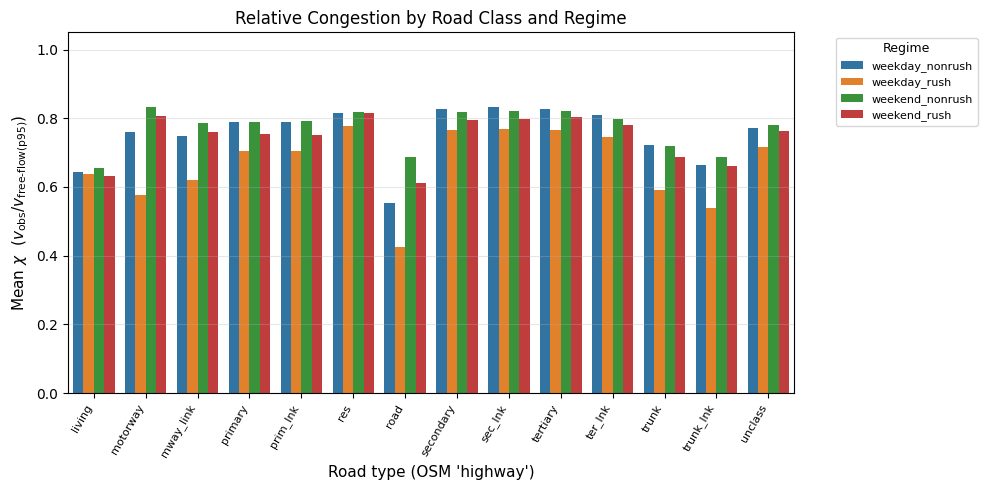

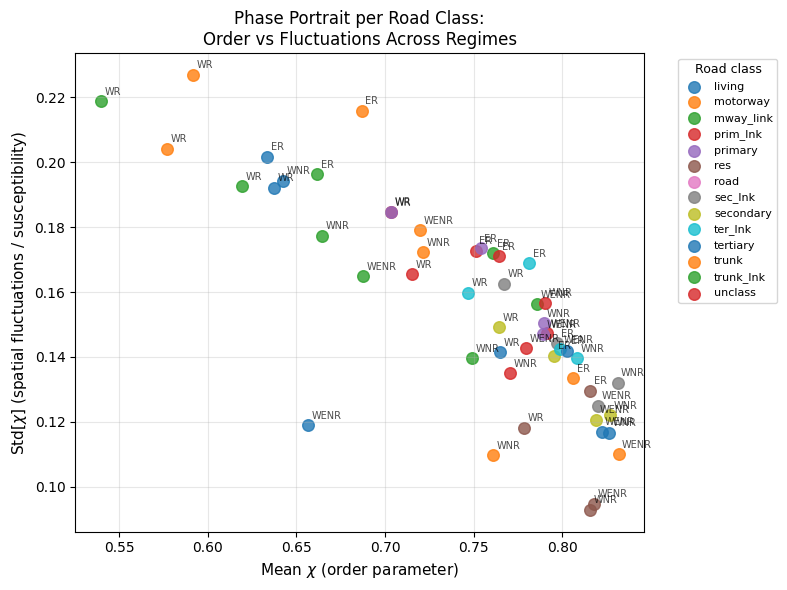

In [35]:
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

###############################################################################
# 0. Assumptions:
#    - time_layers exists and looks like:
#        time_layers = [(label_str, gdf_layer), ...]
#      where each gdf_layer has columns:
#        ["u","v","key","highway","speed_kph_obs","v_ff_edge","chi_ratio", ...]
#      AND geometry, chi_ratio, etc.
#
#    - edges / edges_3414 etc. are already defined earlier (not needed here).
###############################################################################


###############################################################################
# 1. Robustly parse the timestamp label (label -> datetime)
###############################################################################
import re
from datetime import datetime

def parse_time_label_to_dt(label):
    """
    Robustly extract a timestamp from an arbitrary label string.

    We look for:
      - an 8-digit date like 20251025  (YYYYMMDD)
      - followed by a 4-digit time like 1622   (HHMM)

    Examples that will parse:
      "tsb_archive_20251025_1622"
      "archive 20251025 1622"
      "tsbLog_2025-10-25_16-22"
      "2025-10-25 16-22"
      "20251025_0900"

    Returns:
      datetime(...) if we can parse, else None
    """

    lab = str(label)

    # 1. Pull out all groups of digits of length >= 4
    tokens = re.findall(r"\d+", lab)
    # tokens for "tsb_archive_20251025_1622" → ['20251025', '1622']

    # 2. Find a candidate date token (8 digits = YYYYMMDD)
    date_token = None
    time_token = None

    # First pass: find an 8-digit token that looks like YYYYMMDD
    for t in tokens:
        if len(t) == 8:
            date_token = t
            break

    # Second pass: find a 4-digit token that could be HHMM,
    # AFTER the date token in the list
    if date_token is not None:
        date_index = tokens.index(date_token)
        for t in tokens[date_index+1:]:
            if len(t) == 4:
                time_token = t
                break

    # If we still don't have something, bail
    if date_token is None or time_token is None:
        return None

    # Parse date_token → yyyy mm dd
    yyyy = int(date_token[0:4])
    mm   = int(date_token[4:6])
    dd   = int(date_token[6:8])

    # Parse time_token → HH MM
    HH   = int(time_token[0:2])
    MN   = int(time_token[2:4])

    try:
        return datetime(year=yyyy, month=mm, day=dd, hour=HH, minute=MN)
    except Exception:
        return None



###############################################################################
# 2. Classify each timestamp into weekday/weekend + rush/nonrush
###############################################################################
def classify_snapshot_group(dt_obj):
    """
    dt_obj.weekday(): Monday=0 ... Sunday=6
    weekend if 5 or 6
    rush if hour in {9,17}
    """
    if dt_obj is None:
        return "unknown"

    wd = dt_obj.weekday()           # 0=Mon ... 6=Sun
    is_weekend = (wd >= 5)          # Sat=5, Sun=6
    is_rush    = (dt_obj.hour in [9, 17])

    if is_weekend and is_rush:
        return "weekend_rush"
    elif is_weekend and not is_rush:
        return "weekend_nonrush"
    elif (not is_weekend) and is_rush:
        return "weekday_rush"
    else:
        return "weekday_nonrush"


###############################################################################
# 3. Attach datetime/group info and NORMALIZE 'highway'
#    IMPORTANT FIX: make sure 'highway' is ALWAYS a string, never a list.
###############################################################################
def normalize_highway_value(hval):
    """
    OSMnx 'highway' can be:
      - a string like "motorway"
      - a list like ["primary","trunk"]
    We need a single hashable label for grouping.
    Strategy:
      * if list, take first element
      * if nan, fallback "other"
    """
    if isinstance(hval, list):
        if len(hval) == 0:
            return "other"
        return str(hval[0])
    if pd.isna(hval):
        return "other"
    return str(hval)

enriched_layers = []  # [{time_label, dt, group, gdf_norm}, ...]

for (label, gdf_layer) in time_layers:
    # parse timestamp
    dt_obj = parse_time_label_to_dt(label)
    group_label = classify_snapshot_group(dt_obj)

    # make a copy and ensure highway is string (not list)
    gdf_norm = gdf_layer.copy()
    gdf_norm["highway"] = gdf_norm["highway"].apply(normalize_highway_value)

    enriched_layers.append({
        "time_label": label,
        "dt": dt_obj,
        "group": group_label,
        "gdf": gdf_norm
    })

print("[PHASE] Snapshot classification preview:")
for item in enriched_layers[:5]:
    print("   ", item["time_label"], "=>", item["dt"], "=>", item["group"])


###############################################################################
# 4. Build the long per-edge dataset across ALL snapshots
#    Each row: one edge (u,v,key) at one snapshot
###############################################################################
all_edge_rows = []

for item in enriched_layers:
    label = item["time_label"]
    group = item["group"]
    gdf   = item["gdf"]

    for _, r in gdf.iterrows():
        all_edge_rows.append({
            "time_label": label,
            "group": group,
            "u": r.get("u"),
            "v": r.get("v"),
            "key": r.get("key"),
            # highway is now guaranteed to be a string
            "highway": r.get("highway", "other"),
            # χ = observed / edge's personal free-flow (p95)
            "chi_ratio": r.get("chi_ratio", np.nan),
            # speeds for reference
            "v_obs": r.get("speed_kph_obs", np.nan),
            "v_ff_edge": r.get("v_ff_edge", np.nan),
        })

df_all_edges = pd.DataFrame(all_edge_rows)
print("[PHASE] df_all_edges shape:", df_all_edges.shape)
display(df_all_edges.head())

# Clean up infinities
df_all_edges = df_all_edges.replace([np.inf, -np.inf], np.nan)

# OPTIONAL sanity: drop rows where chi_ratio is missing
df_all_edges = df_all_edges.dropna(subset=["chi_ratio", "highway"])

print("[PHASE] df_all_edges after cleanup:", df_all_edges.shape)


###############################################################################
# 5. Aggregate: per-edge within each GROUP
#    We average each edge's behavior across all snapshots that fall
#    into the same group (weekday_rush, etc.)
###############################################################################
def agg_edge_group_stats(df):
    return pd.Series({
        "chi_mean":      np.nanmean(df["chi_ratio"]),
        "chi_median":    np.nanmedian(df["chi_ratio"]),
        "v_obs_mean":    np.nanmean(df["v_obs"]),
        "v_obs_median":  np.nanmedian(df["v_obs"]),
        "v_ff_edge_mean":np.nanmean(df["v_ff_edge"]),
        "n_samples":     len(df)
    })

edge_group_stats = (
    df_all_edges
    .groupby(["group","highway","u","v","key"], dropna=False)
    .apply(agg_edge_group_stats)
    .reset_index()
)

print("[PHASE] edge_group_stats head():")
display(edge_group_stats.head())


###############################################################################
# 6. Aggregate again: road-type × group
#    This gives us a "phase summary" for each road class under each regime.
#
#    chi_bar     = mean( edge-level chi_mean )
#    chi_std     = std(  edge-level chi_mean )
#    severe_frac = share of edges in that class+group with chi_mean < 0.5
###############################################################################
def severe_share(vals, thresh=0.5):
    arr = np.asarray(vals, dtype=float)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return np.nan
    return np.mean(arr < thresh)

roadtype_group_phase = (
    edge_group_stats
    .groupby(["group","highway"], dropna=False)
    .agg(
        chi_bar     =("chi_mean","mean"),          # average congestion order parameter
        chi_std     =("chi_mean","std"),           # spatial variability
        severe_frac =("chi_mean", severe_share)    # fraction near "jammed" (<0.5)
    )
    .reset_index()
)

print("[PHASE] roadtype_group_phase (ROAD TYPE × GROUP):")
display(roadtype_group_phase)


###############################################################################
# 7. City-wide summary per group (across all road classes)
###############################################################################
network_group_phase = (
    edge_group_stats
    .groupby(["group"], dropna=False)
    .agg(
        chi_bar     =("chi_mean","mean"),
        chi_std     =("chi_mean","std"),
        severe_frac =("chi_mean", severe_share)
    )
    .reset_index()
)

print("[PHASE] network_group_phase (Whole SG by regime):")
display(network_group_phase)


###############################################################################
# 8. VISUALIZATION A:
#    Bar chart: mean χ by road class & regime
###############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

# --- optional: shorten highway labels before plotting ---
# OSM 'highway' tags can be long/technical. You can map them to nicer names.
pretty_names = {
    "motorway": "motorway",
    "motorway_link": "mway_link",
    "trunk": "trunk",
    "trunk_link": "trunk_lnk",
    "primary": "primary",
    "primary_link": "prim_lnk",
    "secondary": "secondary",
    "secondary_link": "sec_lnk",
    "tertiary": "tertiary",
    "tertiary_link": "ter_lnk",
    "residential": "res",
    "living_street": "living",
    "service": "service",
    "unclassified": "unclass",
    "road": "road",
    "driveway": "driveway",
    "track": "track",
    "other": "other"
}

roadtype_group_phase_plot = roadtype_group_phase.copy()
roadtype_group_phase_plot["highway_short"] = roadtype_group_phase_plot["highway"].map(
    pretty_names
).fillna(roadtype_group_phase_plot["highway"])

plt.figure(figsize=(10,5))

sns.barplot(
    data=roadtype_group_phase_plot,
    x="highway_short",
    y="chi_bar",
    hue="group"
)

plt.ylim(0, 1.05)
plt.ylabel(r"Mean $\chi$  ($v_{\rm obs} / v_{\rm free\text{-}flow(p95)}$)", fontsize=11)
plt.xlabel("Road type (OSM 'highway')", fontsize=11)
plt.title("Relative Congestion by Road Class and Regime", fontsize=12)

# rotate & shrink tick labels so they don't overlap
plt.xticks(rotation=60, ha="right", fontsize=8)

# also shrink legend text
plt.legend(
    title="Regime",
    bbox_to_anchor=(1.05,1),
    loc="upper left",
    fontsize=8,
    title_fontsize=9
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



###############################################################################
# 9. VISUALIZATION B:
#    Phase portrait: mean χ vs std[χ] for each road class,
#    with points labeled by regime (weekday_rush etc.).
#
#    Interpretation:
#    - chi_bar ~ "order" (how free-flow vs jammed that class tends to be)
#    - chi_std ~ "fluctuations/susceptibility"
#      larger std means that class is unstable/spatially fragmented,
#      which is exactly what we interpret as "near a critical transition".
###############################################################################


# Map long regime names to short 2–3 letter codes for plotting
regime_short_map = {
    "weekday_rush": "WR",
    "weekday_nonrush": "WNR",
    "weekend_rush": "ER",      # 'ER' = "end-of-week rush" or pick "WeR"
    "weekend_nonrush": "WENR", # can shorten to "WNR2" if you like
    "unknown": "UNK"
}

phase_plot_df = roadtype_group_phase_plot.copy()
phase_plot_df["regime_code"] = phase_plot_df["group"].map(regime_short_map).fillna("UNK")
plt.figure(figsize=(8,6))

for road_cat in sorted(phase_plot_df["highway_short"].unique()):
    sub = phase_plot_df[phase_plot_df["highway_short"] == road_cat]

    # scatter each road class (one marker per regime aggregate)
    plt.scatter(
        sub["chi_bar"],
        sub["chi_std"],
        s=70,
        label=road_cat,
        alpha=0.8
    )

    # annotate each point with its regime code instead of long string
    for _, row in sub.iterrows():
        x_ = row["chi_bar"]
        y_ = row["chi_std"]
        code = row["regime_code"]
        if pd.isna(x_) or pd.isna(y_):
            continue

        # tiny offsets to avoid 100% overlap when two regimes are similar
        plt.text(
            x_ + 0.002,
            y_ + 0.002,
            code,
            fontsize=7,
            alpha=0.7
        )

plt.xlabel(r"Mean $\chi$ (order parameter)", fontsize=11)
plt.ylabel(r"Std[$\chi$] (spatial fluctuations / susceptibility)", fontsize=11)
plt.title("Phase Portrait per Road Class:\nOrder vs Fluctuations Across Regimes", fontsize=12)

plt.grid(alpha=0.3)

# slimmer legend with smaller font
plt.legend(
    title="Road class",
    bbox_to_anchor=(1.05,1),
    loc="upper left",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()


In [37]:
roadtype_group_phase_plot['highway'].value_counts()

highway
living_street     4
motorway          4
motorway_link     4
primary           4
primary_link      4
residential       4
road              4
secondary         4
secondary_link    4
tertiary          4
tertiary_link     4
trunk             4
trunk_link        4
unclassified      4
Name: count, dtype: int64

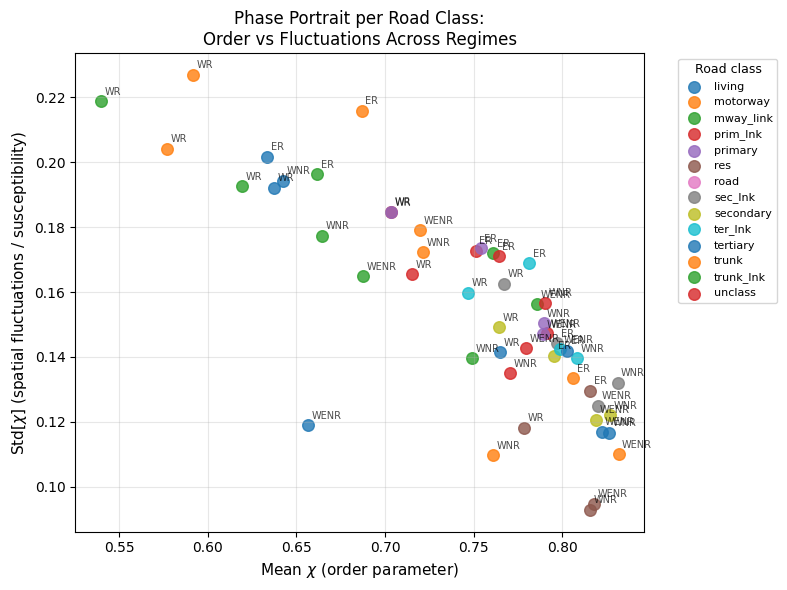

In [34]:
# # Map long regime names to short 2–3 letter codes for plotting
# regime_short_map = {
#     "weekday_rush": "WR",
#     "weekday_nonrush": "WNR",
#     "weekend_rush": "ER",      # 'ER' = "end-of-week rush" or pick "WeR"
#     "weekend_nonrush": "WENR", # can shorten to "WNR2" if you like
#     "unknown": "UNK"
# }

# phase_plot_df = roadtype_group_phase_plot.copy()
# phase_plot_df["regime_code"] = phase_plot_df["group"].map(regime_short_map).fillna("UNK")
# plt.figure(figsize=(8,6))

# for road_cat in sorted(phase_plot_df["highway_short"].unique()):
#     sub = phase_plot_df[phase_plot_df["highway_short"] == road_cat]

#     # scatter each road class (one marker per regime aggregate)
#     plt.scatter(
#         sub["chi_bar"],
#         sub["chi_std"],
#         s=70,
#         label=road_cat,
#         alpha=0.8
#     )

#     # annotate each point with its regime code instead of long string
#     for _, row in sub.iterrows():
#         x_ = row["chi_bar"]
#         y_ = row["chi_std"]
#         code = row["regime_code"]
#         if pd.isna(x_) or pd.isna(y_):
#             continue

#         # tiny offsets to avoid 100% overlap when two regimes are similar
#         plt.text(
#             x_ + 0.002,
#             y_ + 0.002,
#             code,
#             fontsize=7,
#             alpha=0.7
#         )

# plt.xlabel(r"Mean $\chi$ (order parameter)", fontsize=11)
# plt.ylabel(r"Std[$\chi$] (spatial fluctuations / susceptibility)", fontsize=11)
# plt.title("Phase Portrait per Road Class:\nOrder vs Fluctuations Across Regimes", fontsize=12)

# plt.grid(alpha=0.3)

# # slimmer legend with smaller font
# plt.legend(
#     title="Road class",
#     bbox_to_anchor=(1.05,1),
#     loc="upper left",
#     fontsize=8,
#     title_fontsize=9
# )

# plt.tight_layout()
# plt.show()


In [ ]:
# # Map long regime names to short 2–3 letter codes for plotting
# regime_short_map = {
#     "weekday_rush": "WR",
#     "weekday_nonrush": "WNR",
#     "weekend_rush": "ER",      # 'ER' = "end-of-week rush" or pick "WeR"
#     "weekend_nonrush": "WENR", # can shorten to "WNR2" if you like
#     "unknown": "UNK"
# }

# phase_plot_df = roadtype_group_phase_plot.copy()
# phase_plot_df["regime_code"] = phase_plot_df["group"].map(regime_short_map).fillna("UNK")


In [23]:
# import re
# from datetime import datetime
# from collections import defaultdict

# ############################################################
# # Helper: parse time_label like "20251027 1700" -> datetime
# ############################################################
# def parse_time_label_to_dt(label):
#     """
#     Try to parse something like '20251027 1700' or '2025-10-27 17-00'
#     into a Python datetime. We'll be a bit forgiving with separators.

#     We'll try these patterns:
#       YYYYMMDD HHMM
#       YYYY-MM-DD HHMM
#       YYYYMMDD_HHMM
#       YYYY-MM-DD_HHMM
#       etc.
#     """
#     # normalize label (remove spaces, underscores, dashes in the time part)
#     # Example: "2025-10-27 17-00" -> "20251027 1700"
#     lab = label.strip()

#     # Common trick: split into date part and time part using first space if present.
#     # If there's no space, try to guess.
#     if " " in lab:
#         date_part, time_part = lab.split(" ", 1)
#     else:
#         # try underscore
#         if "_" in lab:
#             date_part, time_part = lab.split("_", 1)
#         else:
#             # fallback: assume first 8 chars are date, rest is time
#             date_part, time_part = lab[:8], lab[8:]

#     # remove -, _ from date_part
#     date_part_clean = re.sub(r"[-_]", "", date_part)
#     # remove :, -, _ from time_part
#     time_part_clean = re.sub(r"[:\-_]", "", time_part)

#     # now we expect YYYYMMDD and HHMM
#     # guard lengths
#     if len(date_part_clean) != 8 or len(time_part_clean) < 3:
#         # if we fail, just return None
#         return None

#     yyyy = int(date_part_clean[0:4])
#     mm   = int(date_part_clean[4:6])
#     dd   = int(date_part_clean[6:8])

#     # time_part can be "900" or "0900" etc → zero-pad to 4
#     tp = time_part_clean.zfill(4)
#     HH = int(tp[0:2])
#     MN = int(tp[2:4])

#     try:
#         return datetime(year=yyyy, month=mm, day=dd, hour=HH, minute=MN)
#     except Exception:
#         return None


# ############################################################
# # Helper: classify snapshot into weekday/weekend & rush/nonrush
# ############################################################
# def classify_snapshot_group(dt_obj):
#     """
#     Returns one of:
#       'weekday_rush'
#       'weekday_nonrush'
#       'weekend_rush'
#       'weekend_nonrush'
#     Rush hours defined as hour == 9 or hour == 17.
#     Weekend = Saturday (5) or Sunday (6) in Python's weekday() convention.
#     """
#     if dt_obj is None:
#         return "unknown"

#     hour = dt_obj.hour
#     is_rush = (hour in [9, 17])

#     # weekday(): Monday=0 ... Sunday=6
#     wd = dt_obj.weekday()
#     is_weekend = (wd >= 5)

#     if is_weekend and is_rush:
#         return "weekend_rush"
#     elif is_weekend and not is_rush:
#         return "weekend_nonrush"
#     elif (not is_weekend) and is_rush:
#         return "weekday_rush"
#     else:
#         return "weekday_nonrush"


# ############################################################
# # 1. Attach parsed datetime & group label to each snapshot layer
# ############################################################
# enriched_layers = []  # list of dicts with keys: label, dt, group, gdf
# for (label, gdf_merge) in time_layers:
#     dt_obj = parse_time_label_to_dt(label)
#     group_label = classify_snapshot_group(dt_obj)
#     enriched_layers.append({
#         "time_label": label,
#         "dt": dt_obj,
#         "group": group_label,
#         "gdf": gdf_merge
#     })

# # Optional: inspect what we got
# print("[INFO] Snapshot classification preview:")
# for item in enriched_layers[:5]:
#     print("  ", item["time_label"], "->", item["dt"], "->", item["group"])


# ############################################################
# # 2. Build a long per-edge dataframe with group info for stats
# ############################################################
# all_edge_rows = []

# for item in enriched_layers:
#     label = item["time_label"]
#     group = item["group"]
#     gdf   = item["gdf"]

#     # go row by row (each row is an edge observation at this timestamp)
#     for _, r in gdf.iterrows():
#         all_edge_rows.append({
#             "time_label": label,
#             "group": group,
#             "u": r.get("u"),
#             "v": r.get("v"),
#             "key": r.get("key"),
#             "highway": r.get("highway", "other"),
#             "chi_ratio": r.get("chi_ratio", np.nan),          # = v_obs / v_ff_edge(p95)
#             "v_obs": r.get("speed_kph_obs", np.nan),          # observed speed now
#             "v_ff_edge": r.get("v_ff_edge", np.nan),          # this edge's personal p95 freeflow
#         })

# df_all_edges = pd.DataFrame(all_edge_rows)
# print("[INFO] df_all_edges shape:", df_all_edges.shape)
# display(df_all_edges.head())


# ############################################################
# # 3. Aggregate by (group, highway, edge) to get stable edge stats
# #
# # We'll compute mean chi per edge within each group.
# ############################################################
# edge_group_stats = (
#     df_all_edges
#     .groupby(["group","highway","u","v","key"], as_index=False)
#     .agg(
#         chi_mean=("chi_ratio","mean"),
#         chi_median=("chi_ratio","median"),
#         v_obs_mean=("v_obs","mean"),
#         v_obs_median=("v_obs","median"),
#         v_ff_edge_mean=("v_ff_edge","mean"),
#         n_samples=("chi_ratio","size"),
#     )
# )

# print("[INFO] edge_group_stats (per edge within each group):")
# display(edge_group_stats.head())


# ############################################################
# # 4. Aggregate again by (group, highway) to get ROAD-TYPE-LEVEL
# #    "phase" summary:
# #    - mean chi (order parameter)
# #    - std chi (fluctuations)
# #    - severe share (fraction of edges with chi < 0.5)
# #
# # This is what you'll plot to show "critical loading" by road type.
# ############################################################
# def severe_share(x, thresh=0.5):
#     x = np.asarray(x)
#     x = x[~np.isnan(x)]
#     if len(x)==0:
#         return np.nan
#     return np.mean(x < thresh)

# roadtype_group_phase = (
#     edge_group_stats
#     .groupby(["group","highway"], as_index=False)
#     .agg(
#         chi_bar=("chi_mean","mean"),           # average order param for that road type in that group
#         chi_std=("chi_mean","std"),            # fluctuation ~ "susceptibility"
#         severe_frac=("chi_mean", severe_share) # jammed fraction
#     )
# )

# print("[INFO] roadtype_group_phase (ROAD TYPE × GROUP):")
# display(roadtype_group_phase)


# ############################################################
# # 5. OPTIONAL: also get NETWORK-WIDE summary per group
# ############################################################
# network_group_phase = (
#     edge_group_stats
#     .groupby(["group"], as_index=False)
#     .agg(
#         chi_bar=("chi_mean","mean"),
#         chi_std=("chi_mean","std"),
#         severe_frac=("chi_mean", severe_share)
#     )
# )
# print("[INFO] network_group_phase (whole city by group):")
# display(network_group_phase)


# ############################################################
# # 6. VISUALIZATION 1:
# #    bar chart of chi_bar for each road type in each group.
# #
# #    Interpretation:
# #    lower chi_bar → more congested relative to that road’s
# #    historical best performance → closer to "jammed phase".
# ############################################################
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10,5))
# sns.barplot(
#     data=roadtype_group_phase,
#     x="highway",
#     y="chi_bar",
#     hue="group"
# )
# plt.ylim(0,1.05)
# plt.ylabel(r"Mean $\chi$ (v / v_{\rm freeflow}^{p95})")
# plt.xlabel("Road type (OSM 'highway' class)")
# plt.title("Relative Congestion Level by Road Class and Demand Group")
# plt.legend(title="Group", bbox_to_anchor=(1.05,1), loc="upper left")
# plt.tight_layout()
# plt.show()


# ############################################################
# # 7. VISUALIZATION 2:
# #    For each road type, plot chi_bar vs chi_std across groups.
# #    chi_std ~ fluctuations → think 'susceptibility'
# #    high chi_std at moderate chi_bar often marks a 'critical'
# #    instability region for that class.
# ############################################################
# plt.figure(figsize=(8,6))
# for road_cat in sorted(roadtype_group_phase["highway"].unique()):
#     sub = roadtype_group_phase[roadtype_group_phase["highway"]==road_cat]
#     plt.scatter(sub["chi_bar"], sub["chi_std"], s=80, label=road_cat)
#     for _, r in sub.iterrows():
#         plt.text(r["chi_bar"]+0.005, r["chi_std"]+0.005,
#                  r["group"], fontsize=8, alpha=0.7)

# plt.xlabel(r"Mean $\chi$ (order parameter)")
# plt.ylabel(r"Std $\chi$ (fluctuations / susceptibility)")
# plt.title("Phase Portrait per Road Type:\nOrder vs Fluctuations in Each Regime")
# plt.grid(alpha=0.3)
# plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
# plt.tight_layout()
# plt.show()


[INFO] Snapshot classification preview:
   archive 20251025 1622 -> None -> unknown
   archive 20251025 1700 -> None -> unknown
   archive 20251025 1800 -> None -> unknown
   archive 20251025 2100 -> None -> unknown
   archive 20251026 0000 -> None -> unknown
[INFO] df_all_edges shape: (1378530, 9)


,time_label,group,u,v,key,highway,chi_ratio,v_obs,v_ff_edge
0,archive 20251025 1622,unknown,25451929,6749812859,0,motorway,0.807817,345.611111,427.833333
1,archive 20251025 1622,unknown,25455287,1637003462,0,motorway_link,0.696356,167.192308,240.096154
2,archive 20251025 1622,unknown,25455287,2521018789,0,motorway,0.834038,312.500000,374.683333
3,archive 20251025 1622,unknown,26777521,172424179,0,primary,0.799398,30.653846,38.346154
4,archive 20251025 1622,unknown,26777521,1889379421,0,residential,0.810912,21.700000,26.760000


TypeError: unhashable type: 'list'

## Phase Transition Analysis

[INFO] df_phase rows: 1350120


,time_label,road_cat,chi,rho_proxy,v_obs,v_ff_edge
0,archive 20251025 1622,motorway,0.807817,0.192183,345.611111,427.833333
1,archive 20251025 1622,motorway_link,0.696356,0.303644,167.192308,240.096154
2,archive 20251025 1622,motorway,0.834038,0.165962,312.500000,374.683333
3,archive 20251025 1622,primary,0.799398,0.200602,30.653846,38.346154
4,archive 20251025 1622,residential,0.810912,0.189088,21.700000,26.760000


[INFO] class-time summary:


,road_cat,time_label,rho_mean,chi_mean,rho_std,chi_std,n_edges
0,living_street,archive 20251025 1622,0.486400,0.513600,0.194422,0.194422,19
1,living_street,archive 20251025 1700,0.431858,0.568142,0.198695,0.198695,19
2,living_street,archive 20251025 1800,0.281894,0.762574,0.227783,0.291900,19
3,living_street,archive 20251025 2100,0.424990,0.575010,0.185176,0.185176,19
4,living_street,archive 20251026 0000,0.398437,0.601563,0.208175,0.208175,19


[INFO] road classes: ['living_street' 'motorway' 'motorway_link' 'primary' 'primary_link'
 'residential' 'road' 'secondary' 'secondary_link' 'tertiary'
 'tertiary_link' 'trunk' 'trunk_link' 'unclassified']


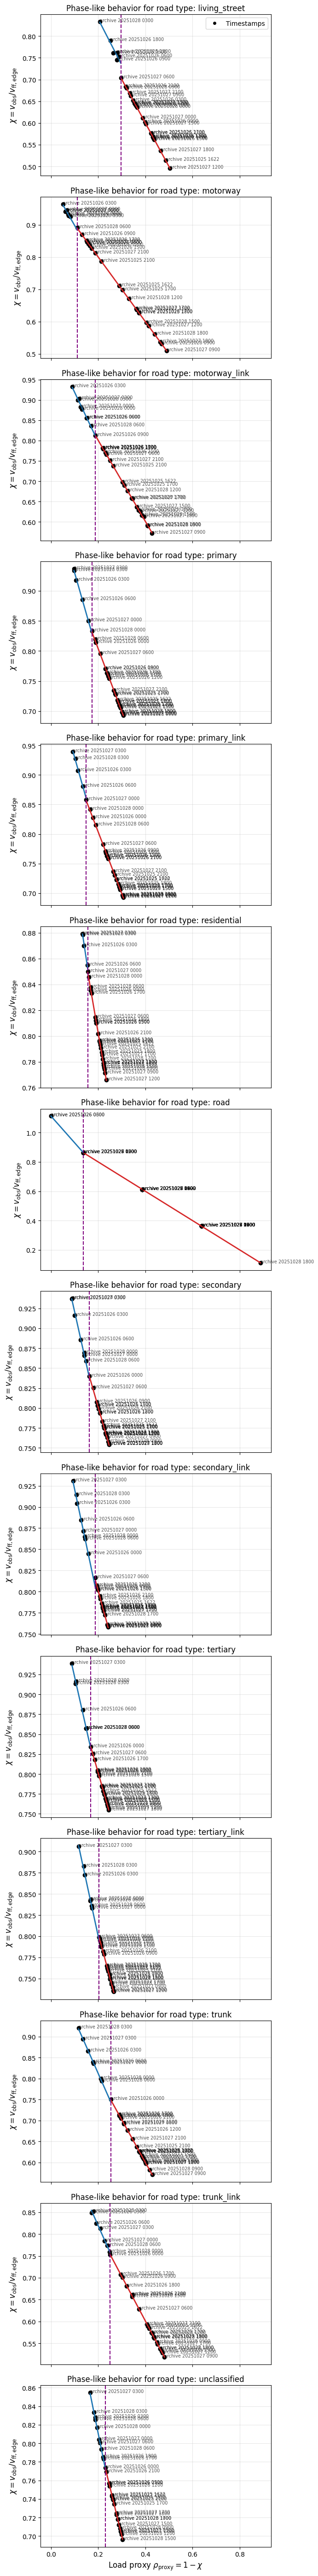

[INFO] Estimated critical load per road type:


,road_cat,rho_c,note
0,living_street,0.296262,estimated critical load proxy where χ slope wo...
1,motorway,0.110878,estimated critical load proxy where χ slope wo...
2,motorway_link,0.188708,estimated critical load proxy where χ slope wo...
3,primary,0.173925,estimated critical load proxy where χ slope wo...
4,primary_link,0.149160,estimated critical load proxy where χ slope wo...
5,residential,0.155804,estimated critical load proxy where χ slope wo...
6,road,0.137500,estimated critical load proxy where χ slope wo...
7,secondary,0.162175,estimated critical load proxy where χ slope wo...
8,secondary_link,0.188675,estimated critical load proxy where χ slope wo...
9,tertiary,0.169007,estimated critical load proxy where χ slope wo...


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------------------------------------------------
# 1. Build a long dataframe of (road_class, load proxy, chi, time)
# ------------------------------------------------------------
#
# We merge every raw snapshot with the baseline so we can compute:
#   chi = v_obs / v_ff_edge
#   rho_proxy = 1 - chi
# and we keep the 'highway' category (road type).
#
# snapshot_layers_raw : list of (time_label, gdf_layer_raw)
# edge_baseline       : per-edge typical free-flow (v_ff_edge)
#
records = []

def normalize_road_cat(x):
    """
    OSMnx 'highway' can be:
      - a string, e.g. 'motorway'
      - a list like ['primary','link']
      - NaN
    We need a hashable, human-readable label.

    Strategy:
    - if list-like: take the first element
    - if string: return as-is
    - else: 'other'
    """
    if isinstance(x, list):
        return x[0] if len(x) > 0 else "other"
    if isinstance(x, tuple):
        return x[0] if len(x) > 0 else "other"
    if isinstance(x, str):
        return x
    return "other"


for (time_label, gdf_layer_raw) in snapshot_layers_raw:
    # Merge in per-edge baseline stats
    merged = gdf_layer_raw.merge(
        edge_baseline,
        on=["u","v","key"],
        how="left"
    )

    # Compute order parameter chi = v_obs / v_ff_edge
    chi = merged["speed_kph_obs"] / merged["v_ff_edge"]

    # "Load" proxy (1 - chi)
    rho_proxy = 1.0 - chi

    # Append per-edge records
    for idx, row in merged.iterrows():
        road_cat_clean = normalize_road_cat(row.get("highway", "other"))

        records.append({
            "time_label": time_label,
            "road_cat": road_cat_clean,
            "chi": chi.iloc[idx],
            "rho_proxy": rho_proxy.iloc[idx],
            "v_obs": row.get("speed_kph_obs", np.nan),
            "v_ff_edge": row.get("v_ff_edge", np.nan),
        })

# Convert to DataFrame
df_phase = pd.DataFrame(records)

# ------------------------------------------------------------
# 2. Clean df_phase (remove junk / clip physical ranges)
# ------------------------------------------------------------
df_phase = df_phase.replace([np.inf, -np.inf], np.nan)

# drop rows where we can't define chi or rho_proxy or the road_cat
df_phase = df_phase.dropna(subset=["chi","rho_proxy","road_cat"]).copy()

# sanity bounds:
#   chi shouldn't be negative, and can be slightly >1 if obs>baseline
df_phase["chi"] = df_phase["chi"].clip(lower=0, upper=1.2)

#   rho_proxy = 1-chi, keep in a reasonable range
df_phase["rho_proxy"] = df_phase["rho_proxy"].clip(lower=0, upper=2.0)

# Final safety: normalize any leftover weird 'road_cat' values
df_phase["road_cat"] = df_phase["road_cat"].apply(normalize_road_cat)

print("[INFO] df_phase rows:", len(df_phase))
display(df_phase.head())

# ------------------------------------------------------------
# 3. Aggregate per (road_cat, time_label)
#    Each point here is: "this road class at this timestamp"
#    We compute means and std across all edges that belong
#    to that road class at that time.
# ------------------------------------------------------------
df_class_time = (
    df_phase
    .groupby(["road_cat","time_label"], as_index=False)
    .agg(
        rho_mean=("rho_proxy","mean"),
        chi_mean=("chi","mean"),
        rho_std=("rho_proxy","std"),
        chi_std=("chi","std"),
        n_edges=("chi","size"),
    )
)

print("[INFO] class-time summary:")
display(df_class_time.head())

# ------------------------------------------------------------
# 4. Helper: piecewise-linear breakpoint fitter
#    We treat chi_mean vs rho_mean as two regimes:
#    - left: near-free flow
#    - right: congested
#    We brute-force a breakpoint x* that minimizes SSE.
# ------------------------------------------------------------
def fit_two_segment_breakpoint(x, y, min_pts=4):
    """
    Fit a 2-segment linear model with a breakpoint.
    We sweep possible break indices in sorted x.

    Returns dict:
        {
          'x_star': breakpoint in rho,
          'a1','b1': left-segment intercept & slope,
          'a2','b2': right-segment intercept & slope,
          'sse_min': total SSE
        }
    or None if not enough data.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if len(x) < min_pts:
        return None

    # sort by x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    best = None
    n = len(x_sorted)

    # require >=2 points in each segment
    for i in range(2, n-1):
        x_left  = x_sorted[:i]
        y_left  = y_sorted[:i]
        x_right = x_sorted[i:]
        y_right = y_sorted[i:]

        # left fit
        A_left = np.column_stack([np.ones_like(x_left), x_left])
        coef_left, _, _, _ = np.linalg.lstsq(A_left, y_left, rcond=None)
        a1, b1 = coef_left

        # right fit
        A_right = np.column_stack([np.ones_like(x_right), x_right])
        coef_right, _, _, _ = np.linalg.lstsq(A_right, y_right, rcond=None)
        a2, b2 = coef_right

        # SSE of both pieces
        yhat_left  = a1 + b1*x_left
        yhat_right = a2 + b2*x_right
        sse = np.sum((y_left - yhat_left)**2) + np.sum((y_right - yhat_right)**2)

        if (best is None) or (sse < best["sse_min"]):
            best = {
                "x_star": x_sorted[i],
                "a1": a1, "b1": b1,
                "a2": a2, "b2": b2,
                "sse_min": sse,
            }

    return best

# ------------------------------------------------------------
# 5. Fit breakpoint per road class and plot
# ------------------------------------------------------------
unique_classes = df_class_time["road_cat"].unique()
print("[INFO] road classes:", unique_classes)

fig, axes = plt.subplots(
    nrows=len(unique_classes),
    ncols=1,
    figsize=(7, 4*len(unique_classes)),
    sharex=True
)

if len(unique_classes) == 1:
    axes = [axes]  # make iterable if only one class

breakpoint_table = []

for ax, road_cat in zip(axes, unique_classes):
    sub = df_class_time[df_class_time["road_cat"] == road_cat].sort_values("rho_mean")

    x = sub["rho_mean"].values      # load proxy
    y = sub["chi_mean"].values      # order parameter

    # scatter each timestamp point
    ax.scatter(x, y, color="black", label=f"{road_cat} snapshots")
    for _, row in sub.iterrows():
        ax.text(
            row["rho_mean"],
            row["chi_mean"],
            row["time_label"],
            fontsize=7,
            alpha=0.7
        )

    # breakpoint fit
    bp = fit_two_segment_breakpoint(x, y, min_pts=4)
    if bp is not None:
        rho_c = bp["x_star"]
        a1,b1 = bp["a1"], bp["b1"]
        a2,b2 = bp["a2"], bp["b2"]

        # fit lines for visualization
        x_left  = np.linspace(min(x), rho_c, 20)
        x_right = np.linspace(rho_c, max(x), 20)
        y_left_fit  = a1 + b1*x_left
        y_right_fit = a2 + b2*x_right

        ax.plot(x_left,  y_left_fit,  color="tab:blue", linewidth=2)
        ax.plot(x_right, y_right_fit, color="tab:red",  linewidth=2)

        ax.axvline(
            rho_c,
            color="purple",
            linestyle="--",
            linewidth=1.5,
            label=fr"$\rho_c \approx {rho_c:.2f}$"
        )

        breakpoint_table.append({
            "road_cat": road_cat,
            "rho_c": rho_c,
            "note": "estimated critical load proxy where χ slope worsens"
        })

    ax.set_ylabel(r"$\chi = v_{\rm obs} / v_{\rm ff,edge}$", fontsize=12)
    ax.set_title(f"Phase-like behavior for road type: {road_cat}")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel(r"Load proxy $\rho_{\rm proxy} = 1 - \chi$", fontsize=12)

# legend for first subplot
point_legend = Line2D(
    [0],[0],
    marker='o',
    color='w',
    markerfacecolor='black',
    label='Timestamps',
    markersize=6
)
axes[0].legend(handles=[point_legend], loc="upper right")

plt.tight_layout()
plt.show()

# Final table of critical loads
crit_df = pd.DataFrame(breakpoint_table)
print("[INFO] Estimated critical load per road type:")
display(crit_df)
